In [5]:
import importlib

# List of all key packages we expect for the 3 projects
packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "yfinance",
    "statsmodels",
    "sklearn",
    "xgboost",
    "lightgbm"
]

failed = []
for pkg in packages:
    try:
        importlib.import_module(pkg)
        print(f"✅ {pkg} is installed and working")
    except ImportError as e:
        print(f"❌ {pkg} NOT working: {e}")
        failed.append(pkg)

if not failed:
    print("\n🎉 All packages imported successfully — environment is ready!")
else:
    print("\n⚠️ Missing or broken packages:", failed)

✅ numpy is installed and working
✅ pandas is installed and working
✅ matplotlib is installed and working
✅ seaborn is installed and working
✅ yfinance is installed and working
✅ statsmodels is installed and working
✅ sklearn is installed and working
✅ xgboost is installed and working
✅ lightgbm is installed and working

🎉 All packages imported successfully — environment is ready!


/var/folders/9r/6bg33mrn1fq4yxp4zgfc40w00000gn/T/ipykernel_41374/778163701.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  10 of 10 completed


Price           Close                                                          \
Ticker            BAC         BK          C          GS        JPM         MS   
Date                                                                            
2018-01-02  25.044065  43.367767  57.213619  216.480865  87.151993  41.314873   
2018-01-03  24.960306  43.633686  57.390587  214.465729  87.240837  41.425697   
2018-01-04  25.286966  44.068806  58.098450  217.463074  88.490608  42.058990   
2018-01-05  25.404232  44.181625  58.021511  216.353897  87.922516  42.043152   
2018-01-08  25.228340  44.366951  57.344425  213.212585  88.052361  41.869007   

Price                                                    ...    Volume  \
Ticker             PNC        TFC        USB        WFC  ...       BAC   
Date                                                     ...             
2018-01-02  110.623039  35.888393  40.227280  49.149498  ...  57121600   
2018-01-03  110.600098  36.276600  40.621880  49.527634

/Users/aghnadatta/Documents/Quant/Quant Portfolio/01_stat_arb_pairs_trading/utils.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.dropna(how='all').fillna(method='ffill')


Downloaded 1905 days of data for 10 tickers.

Cointegrated Pairs (p < 0.05):
BAC & PNC | p-value = 0.0035
TFC & USB | p-value = 0.0135

Performance Report:
Annualized Return: -0.0076
Annualized Volatility: 0.0446
Sharpe Ratio: -0.1710
Max Drawdown: -0.1529
Win Rate: 0.0210


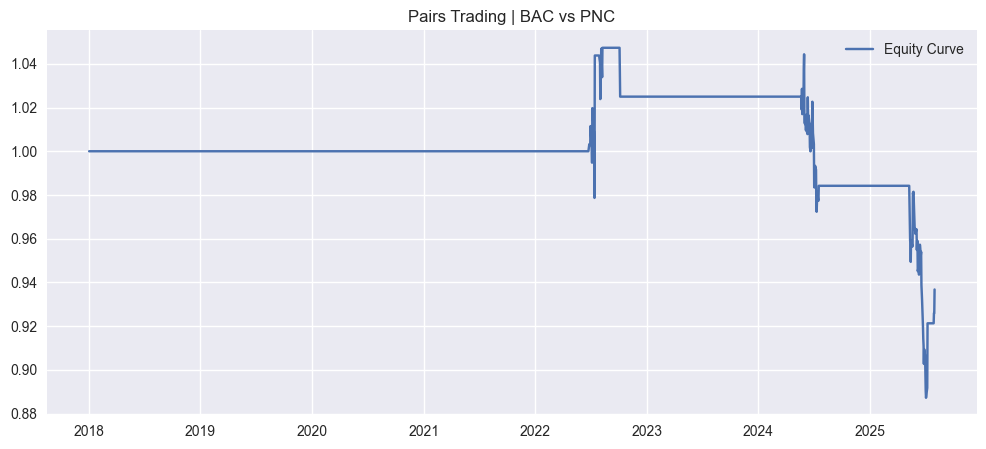

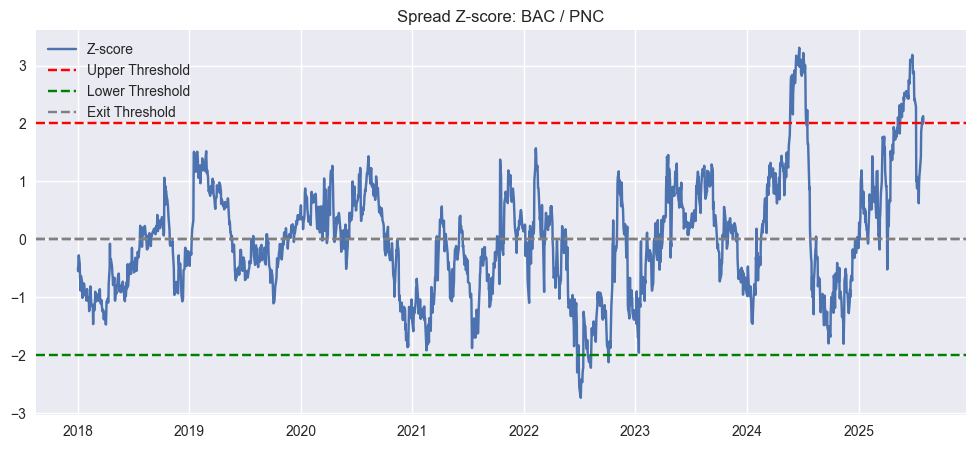

In [6]:
# --------------------------------------
# 0. Imports & Config
# --------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from utils import fetch_data, find_cointegrated_pairs, backtest_pairs, performance_metrics, plot_zscore

plt.style.use('seaborn-v0_8')

import yfinance as yf
tickers = ["JPM", "BAC", "WFC", "C", "GS", "MS", "USB", "PNC", "TFC", "BK"]
start_date = "2018-01-01"
end_date = "2025-08-01"

raw = yf.download(tickers, start=start_date, end=end_date)
print(raw.head())
print("\nColumns:", raw.columns)
print("\nIs MultiIndex:", isinstance(raw.columns, pd.MultiIndex))



# --------------------------------------
# 1. Fetch Price Data
# --------------------------------------
tickers = ["JPM", "BAC", "WFC", "C", "GS", "MS", "USB", "PNC", "TFC", "BK"]
start_date = "2018-01-01"
end_date = "2025-08-01"

prices = fetch_data(tickers, start_date, end_date, save_path="data/prices.csv")
print(f"Downloaded {prices.shape[0]} days of data for {prices.shape[1]} tickers.")

# --------------------------------------
# 2. Cointegration Tests
# --------------------------------------
_, pairs = find_cointegrated_pairs(prices)

print("\nCointegrated Pairs (p < 0.05):")
for t1, t2, p in pairs:
    print(f"{t1} & {t2} | p-value = {p:.4f}")

# Select first cointegrated pair for backtest
if not pairs:
    raise ValueError("No cointegrated pairs found. Try changing tickers/sector.")
pair = (pairs[0][0], pairs[0][1])

# --------------------------------------
# 3. Backtest Strategy
# --------------------------------------
equity_curve, daily_returns, zscore = backtest_pairs(prices, pair)

# --------------------------------------
# 4. Performance Metrics
# --------------------------------------
metrics = performance_metrics(daily_returns)
print("\nPerformance Report:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# --------------------------------------
# 5. Plots
# --------------------------------------
plt.figure(figsize=(12,5))
plt.plot(equity_curve, label="Equity Curve")
plt.title(f"Pairs Trading | {pair[0]} vs {pair[1]}")
plt.legend()
plt.show()

plot_zscore(zscore, title=f"Spread Z-score: {pair[0]} / {pair[1]}")

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Win Rate,p-value
Pair,,,,,,
TFC-USB,0.031588,0.036125,0.874413,-0.045640,0.024147,0.013454
BAC-PNC,-0.007634,0.044639,-0.171022,-0.152898,0.020997,0.003504



Metrics saved to data/pair_metrics.csv


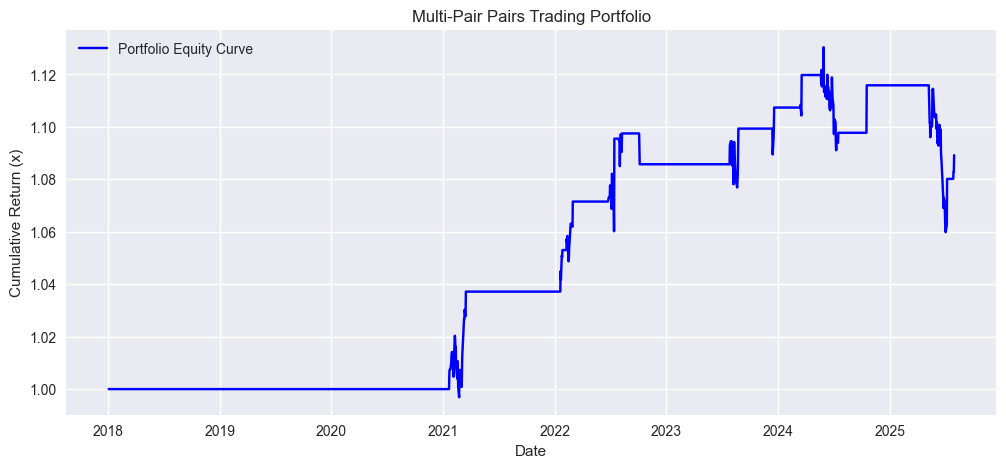

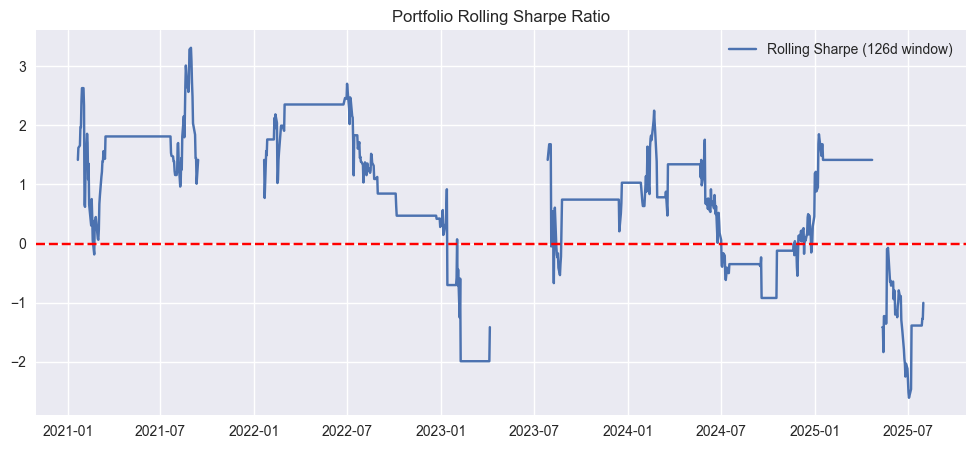


Portfolio Performance:
Annualized Return: 0.0118
Annualized Volatility: 0.0287
Sharpe Ratio: 0.4103
Max Drawdown: -0.0624
Win Rate: 0.0451


In [7]:
from collections import defaultdict
import numpy as np

# --------------------------------------
# Multi-Pair Portfolio Backtest
# --------------------------------------

results = []
returns_dict = {}
entry_z = 2
exit_z = 0

for t1, t2, pval in pairs:
    equity, rets, _ = backtest_pairs(prices, (t1, t2), entry_z, exit_z)
    metrics = performance_metrics(rets)
    metrics["Pair"] = f"{t1}-{t2}"
    metrics["p-value"] = pval
    results.append(metrics)
    returns_dict[f"{t1}-{t2}"] = rets

# Create metrics DataFrame
metrics_df = pd.DataFrame(results).set_index("Pair").sort_values("Sharpe Ratio", ascending=False)
display(metrics_df)

# Export to CSV
metrics_df.to_csv("data/pair_metrics.csv")
print("\nMetrics saved to data/pair_metrics.csv")

# --------------------------------------
# Portfolio Construction (Equal Weight)
# --------------------------------------
returns_df = pd.DataFrame(returns_dict).fillna(0)
portfolio_returns = returns_df.mean(axis=1)
portfolio_equity = (1 + portfolio_returns).cumprod()

# --------------------------------------
# Plot Portfolio Equity Curve
# --------------------------------------
plt.figure(figsize=(12,5))
plt.plot(portfolio_equity, label="Portfolio Equity Curve", color="blue")
plt.title("Multi-Pair Pairs Trading Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (x)")
plt.legend()
plt.show()

# --------------------------------------
# Rolling Sharpe Ratio
# --------------------------------------
def rolling_sharpe(returns, window=126):
    """Calculate rolling annualized Sharpe ratio."""
    roll_mean = returns.rolling(window).mean()
    roll_vol = returns.rolling(window).std()
    return (roll_mean / roll_vol) * np.sqrt(252)

rolling_sharpe_ratio = rolling_sharpe(portfolio_returns)

plt.figure(figsize=(12,5))
plt.plot(rolling_sharpe_ratio, label="Rolling Sharpe (126d window)")
plt.axhline(0, color='red', linestyle='--')
plt.title("Portfolio Rolling Sharpe Ratio")
plt.legend()
plt.show()

# --------------------------------------
# Portfolio Performance Metrics
# --------------------------------------
portfolio_metrics = performance_metrics(portfolio_returns)
print("\nPortfolio Performance:")
for k, v in portfolio_metrics.items():
    print(f"{k}: {v:.4f}")

✅ Quant_Research_Report.pdf saved. Includes portfolio + all individual pairs.


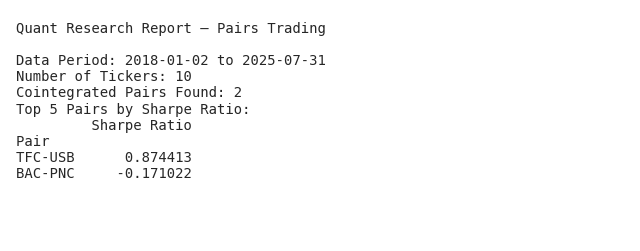

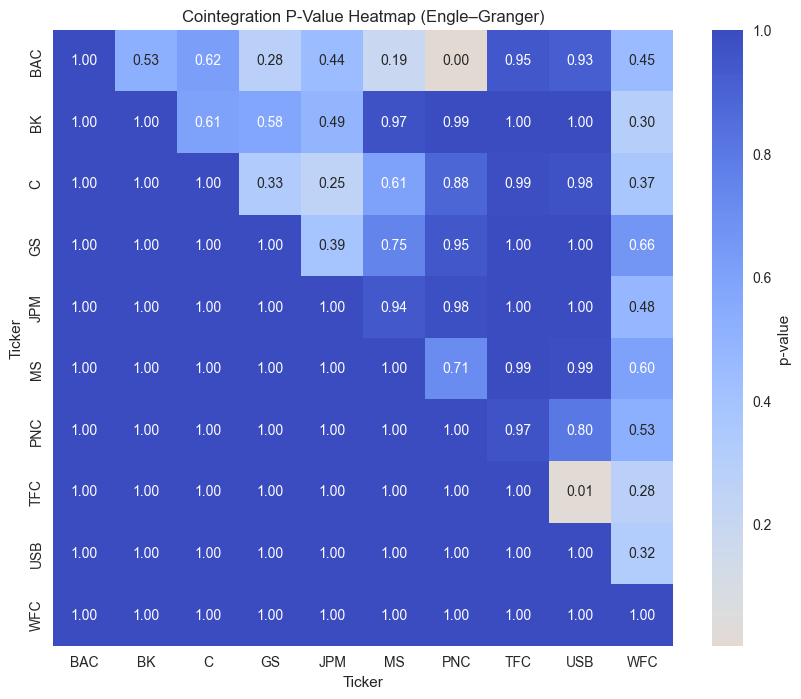

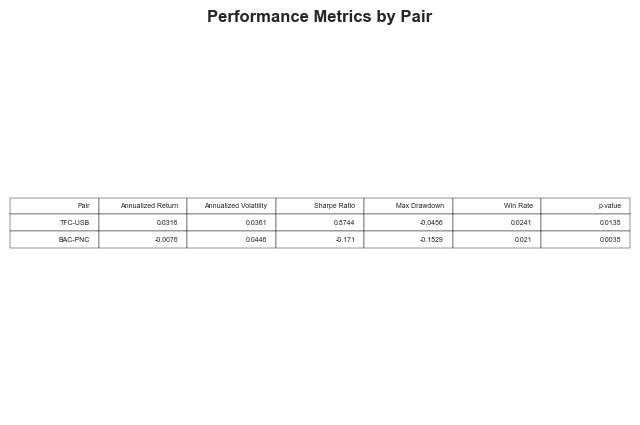

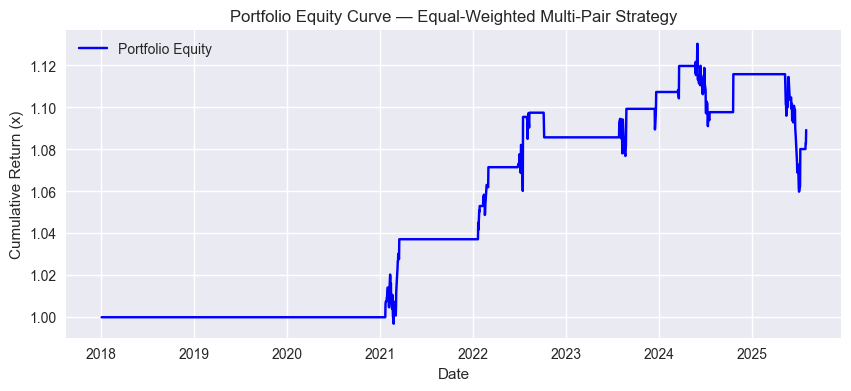

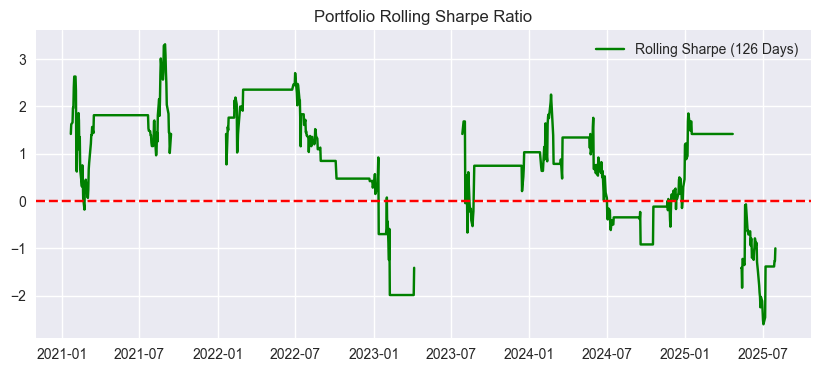

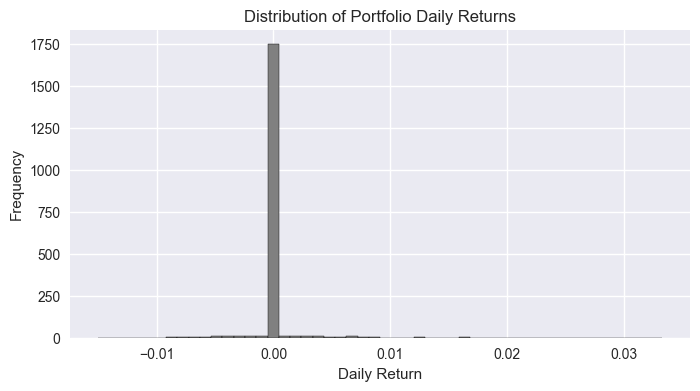

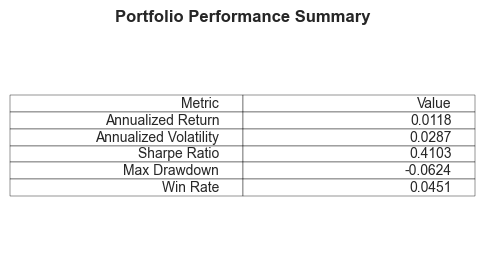

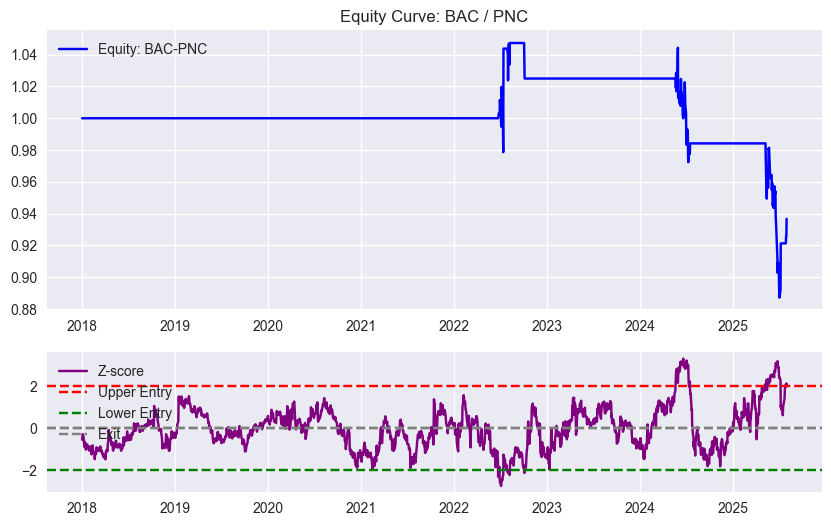

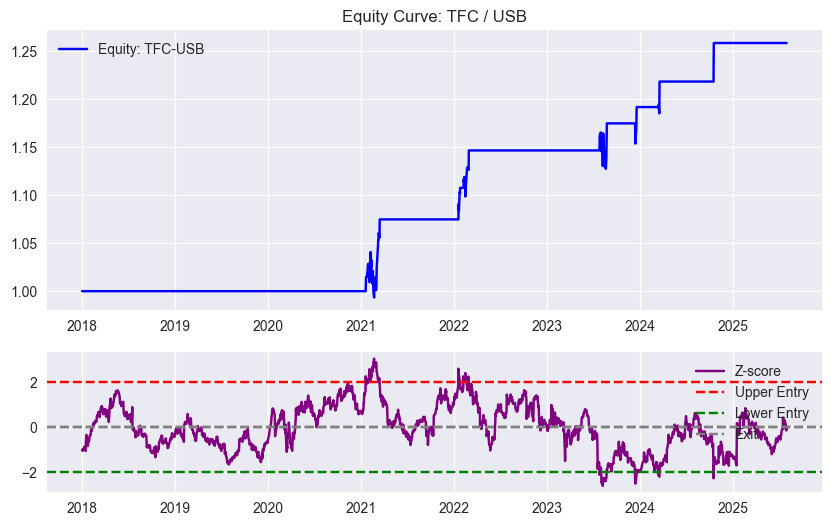

In [8]:
import matplotlib.backends.backend_pdf as backend_pdf
import seaborn as sns
import numpy as np

# ======================================
# 1. Re-run cointegration & backtests
# ======================================
pval_matrix, pairs = find_cointegrated_pairs(prices)
returns_dict = {}
results = []
entry_z, exit_z = 2, 0

for t1, t2, pval in pairs:
    equity, rets, zscore = backtest_pairs(prices, (t1, t2), entry_z, exit_z)
    metrics = performance_metrics(rets)
    metrics["Pair"] = f"{t1}-{t2}"
    metrics["p-value"] = pval
    results.append(metrics)
    returns_dict[f"{t1}-{t2}"] = rets

metrics_df = pd.DataFrame(results).set_index("Pair").sort_values("Sharpe Ratio", ascending=False)
returns_df = pd.DataFrame(returns_dict).fillna(0)
portfolio_returns = returns_df.mean(axis=1)
portfolio_equity = (1 + portfolio_returns).cumprod()

# ======================================
# 2. Create PDF Report
# ======================================
pdf = backend_pdf.PdfPages("Quant_Research_Report.pdf")

# ---- Overview ----
fig, ax = plt.subplots(figsize=(8,3))
ax.axis('off')
overview_text = (
    f"Quant Research Report — Pairs Trading\n\n"
    f"Data Period: {prices.index.min().date()} to {prices.index.max().date()}\n"
    f"Number of Tickers: {len(prices.columns)}\n"
    f"Cointegrated Pairs Found: {len(pairs)}\n"
    f"Top 5 Pairs by Sharpe Ratio:\n" +
    metrics_df.head(5)[['Sharpe Ratio']].to_string()
)
ax.text(0.01, 0.95, overview_text, ha='left', va='top', fontsize=10, family='monospace')
pdf.savefig(fig)

# ---- P-Value Heatmap ----
pval_df = pd.DataFrame(pval_matrix, index=prices.columns, columns=prices.columns)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pval_df, annot=True, fmt=".2f", cmap="coolwarm_r", center=0.05, cbar_kws={'label': 'p-value'}, ax=ax)
ax.set_title("Cointegration P-Value Heatmap (Engle–Granger)")
pdf.savefig(fig)

# ---- Metrics Table ----
fig, ax = plt.subplots(figsize=(8, max(5, len(metrics_df)*0.4)))
ax.axis('off')
ax.set_title("Performance Metrics by Pair", fontweight='bold')
table_data = metrics_df.round(4).reset_index()
ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='right', colLoc='right')
pdf.savefig(fig)

# ---- Portfolio Equity Curve ----
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(portfolio_equity, color="blue", label="Portfolio Equity")
ax.set_title("Portfolio Equity Curve — Equal-Weighted Multi-Pair Strategy")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative Return (x)")
ax.legend()
pdf.savefig(fig)

# ---- Rolling Sharpe ----
def rolling_sharpe(returns, window=126):
    roll_mean = returns.rolling(window).mean()
    roll_vol = returns.rolling(window).std()
    return (roll_mean / roll_vol) * np.sqrt(252)

rolling_sharpe_ratio = rolling_sharpe(portfolio_returns)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(rolling_sharpe_ratio, label="Rolling Sharpe (126 Days)", color="green")
ax.axhline(0, color="red", linestyle="--")
ax.set_title("Portfolio Rolling Sharpe Ratio")
ax.legend()
pdf.savefig(fig)

# ---- Histogram of Daily Returns ----
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(portfolio_returns, bins=50, color='grey', edgecolor='black')
ax.set_title("Distribution of Portfolio Daily Returns")
ax.set_xlabel("Daily Return"); ax.set_ylabel("Frequency")
pdf.savefig(fig)

# ---- Portfolio Performance Summary ----
fig, ax = plt.subplots(figsize=(6,3))
ax.axis('off')
summary_data = performance_metrics(portfolio_returns)
summary_df = pd.DataFrame(list(summary_data.items()), columns=["Metric", "Value"]).round(4)
ax.table(cellText=summary_df.values, colLabels=summary_df.columns, loc='center', cellLoc='right', colLoc='right')
ax.set_title("Portfolio Performance Summary", fontweight='bold')
pdf.savefig(fig)

# ======================================
# 3. Individual Pair Equity & Z-Score Plots
# ======================================
for t1, t2, _ in pairs:
    equity, rets, zscore = backtest_pairs(prices, (t1, t2), entry_z, exit_z)

    # Equity curve for pair
    fig, ax = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={"height_ratios":[2,1]})

    ax[0].plot(equity, label=f"Equity: {t1}-{t2}", color="blue")
    ax[0].set_title(f"Equity Curve: {t1} / {t2}")
    ax[0].legend()

    # Z-score plot with thresholds
    ax[1].plot(zscore, label="Z-score", color="purple")
    ax[1].axhline(entry_z, color="red", linestyle="--", label="Upper Entry")
    ax[1].axhline(-entry_z, color="green", linestyle="--", label="Lower Entry")
    ax[1].axhline(exit_z, color="grey", linestyle="--", label="Exit")
    ax[1].axhline(-exit_z, color="grey", linestyle="--")
    ax[1].legend()

    pdf.savefig(fig)

# ======================================
# 4. Save PDF
# ======================================
pdf.close()
print("✅ Quant_Research_Report.pdf saved. Includes portfolio + all individual pairs.")

✅ Quant_Research_Report.pdf saved. Includes portfolio + all individual pairs.


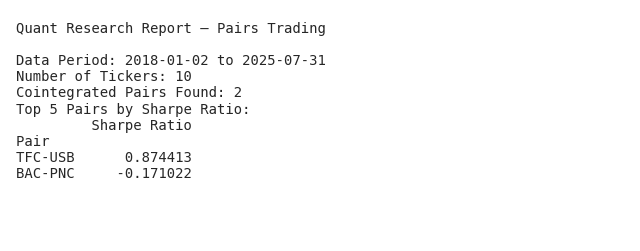

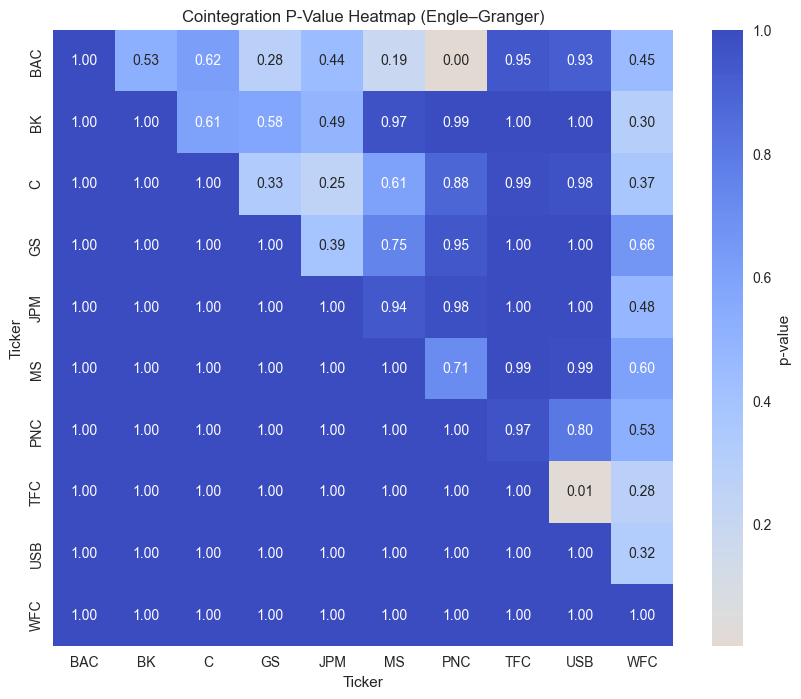

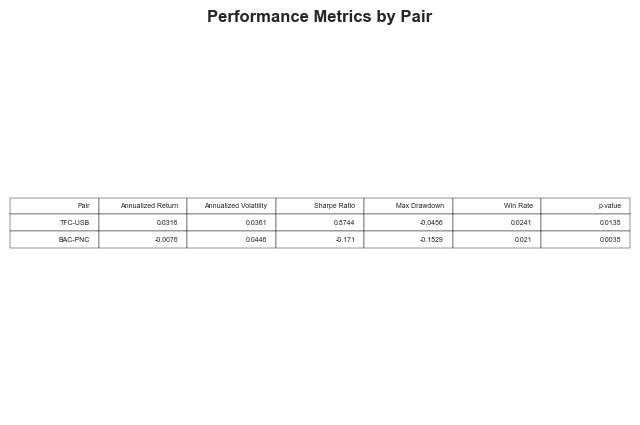

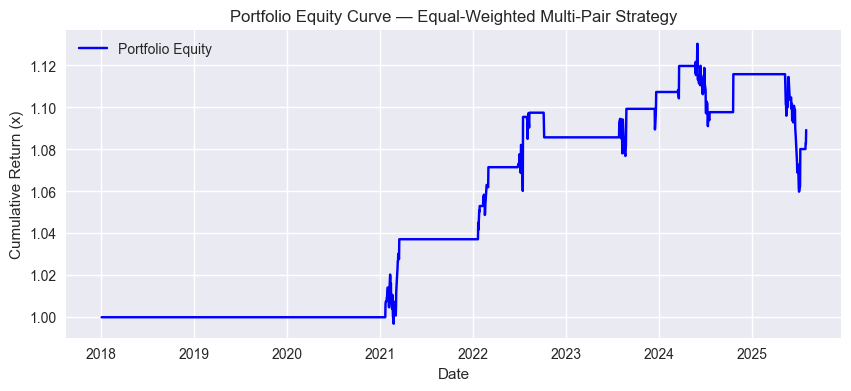

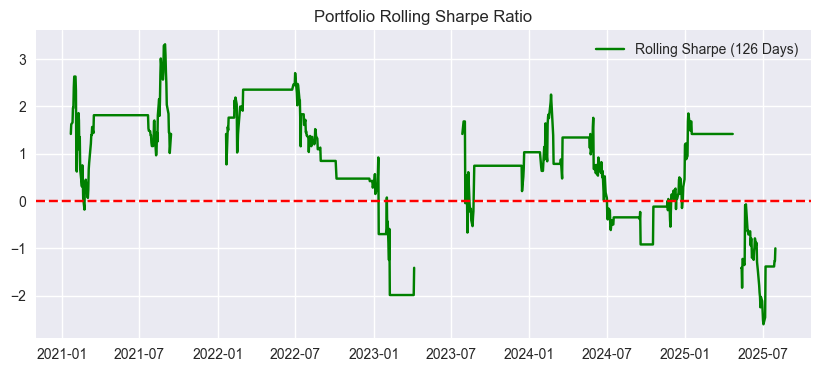

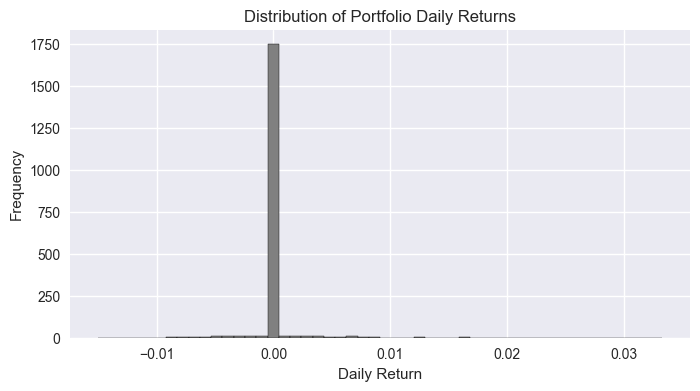

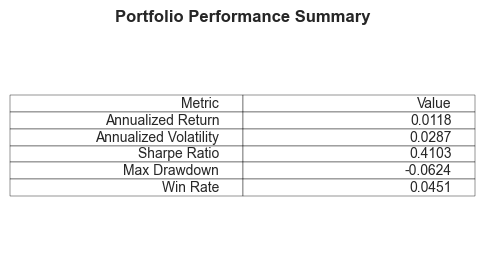

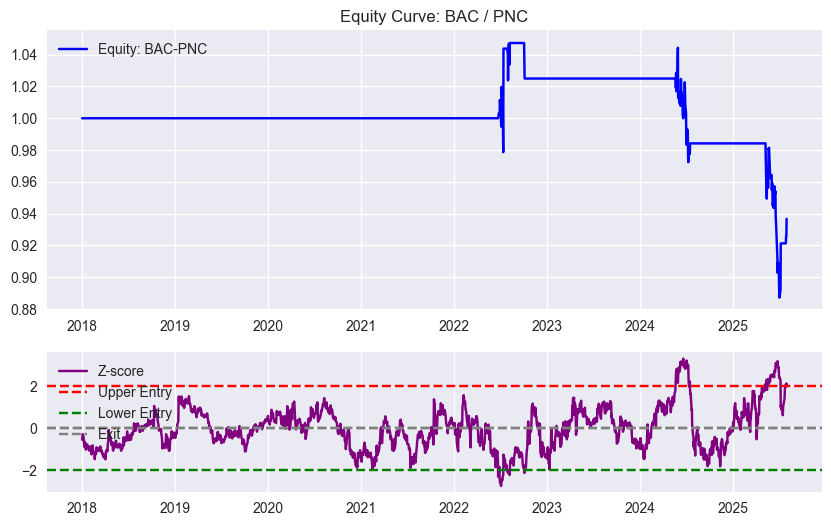

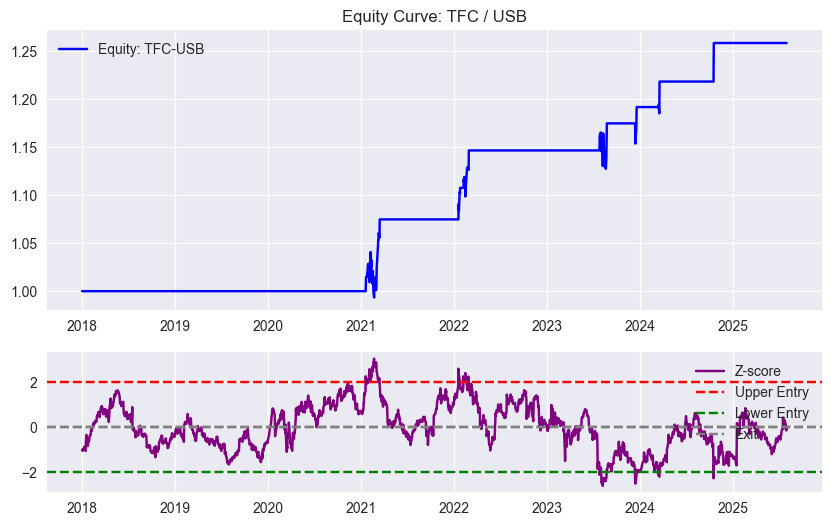

In [ ]:
import matplotlib.backends.backend_pdf as backend_pdf
import seaborn as sns
import numpy as np

# Make sure utils.py is in the same folder
from utils import find_cointegrated_pairs, backtest_pairs, performance_metrics, plot_zscore

# ======================================
# 1. Re-run cointegration & backtests
# ======================================
pval_matrix, pairs = find_cointegrated_pairs(prices)
returns_dict = {}
results = []
entry_z, exit_z = 2, 0

for t1, t2, pval in pairs:
    equity, rets, zscore = backtest_pairs(prices, (t1, t2), entry_z, exit_z)
    metrics = performance_metrics(rets)
    metrics["Pair"] = f"{t1}-{t2}"
    metrics["p-value"] = pval
    results.append(metrics)
    returns_dict[f"{t1}-{t2}"] = rets

metrics_df = pd.DataFrame(results).set_index("Pair").sort_values("Sharpe Ratio", ascending=False)
returns_df = pd.DataFrame(returns_dict).fillna(0)
portfolio_returns = returns_df.mean(axis=1)
portfolio_equity = (1 + portfolio_returns).cumprod()

# ======================================
# 2. Create PDF Report
# ======================================
pdf = backend_pdf.PdfPages("Quant_Research_Report.pdf")

# ---- Overview ----
fig, ax = plt.subplots(figsize=(8,3))
ax.axis('off')
overview_text = (
    f"Quant Research Report — Pairs Trading\n\n"
    f"Data Period: {prices.index.min().date()} to {prices.index.max().date()}\n"
    f"Number of Tickers: {len(prices.columns)}\n"
    f"Cointegrated Pairs Found: {len(pairs)}\n"
    f"Top 5 Pairs by Sharpe Ratio:\n" +
    metrics_df.head(5)[['Sharpe Ratio']].to_string()
)
ax.text(0.01, 0.95, overview_text, ha='left', va='top', fontsize=10, family='monospace')
pdf.savefig(fig)

# ---- P-Value Heatmap ----
pval_df = pd.DataFrame(pval_matrix, index=prices.columns, columns=prices.columns)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pval_df, annot=True, fmt=".2f", cmap="coolwarm_r", center=0.05, cbar_kws={'label': 'p-value'}, ax=ax)
ax.set_title("Cointegration P-Value Heatmap (Engle–Granger)")
pdf.savefig(fig)
plt.savefig("images/heatmap_new.png", dpi=300, bbox_inches="tight")

# ---- Metrics Table ----
fig, ax = plt.subplots(figsize=(8, max(5, len(metrics_df)*0.4)))
ax.axis('off')
ax.set_title("Performance Metrics by Pair", fontweight='bold')
table_data = metrics_df.round(4).reset_index()
ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='right', colLoc='right')
pdf.savefig(fig)

# ---- Portfolio Equity Curve ----
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(portfolio_equity, color="blue", label="Portfolio Equity")
ax.set_title("Portfolio Equity Curve — Equal-Weighted Multi-Pair Strategy")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative Return (x)")
ax.legend()
pdf.savefig(fig)


# ---- Rolling Sharpe ----
def rolling_sharpe(returns, window=126):
    roll_mean = returns.rolling(window).mean()
    roll_vol = returns.rolling(window).std()
    return (roll_mean / roll_vol) * np.sqrt(252)

rolling_sharpe_ratio = rolling_sharpe(portfolio_returns)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(rolling_sharpe_ratio, label="Rolling Sharpe (126 Days)", color="green")
ax.axhline(0, color="red", linestyle="--")
ax.set_title("Portfolio Rolling Sharpe Ratio")
ax.legend()
pdf.savefig(fig)

# ---- Histogram of Daily Returns ----
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(portfolio_returns, bins=50, color='grey', edgecolor='black')
ax.set_title("Distribution of Portfolio Daily Returns")
ax.set_xlabel("Daily Return"); ax.set_ylabel("Frequency")
pdf.savefig(fig)

# ---- Portfolio Performance Summary ----
fig, ax = plt.subplots(figsize=(6,3))
ax.axis('off')
summary_data = performance_metrics(portfolio_returns)
summary_df = pd.DataFrame(list(summary_data.items()), columns=["Metric", "Value"]).round(4)
ax.table(cellText=summary_df.values, colLabels=summary_df.columns, loc='center', cellLoc='right', colLoc='right')
ax.set_title("Portfolio Performance Summary", fontweight='bold')
pdf.savefig(fig)

# ======================================
# 3. Individual Pair Equity & Z-Score Plots
# ======================================
for t1, t2, _ in pairs:
    equity, rets, zscore = backtest_pairs(prices, (t1, t2), entry_z, exit_z)

    # Equity curve for pair
    fig, ax = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={"height_ratios":[2,1]})

    ax[0].plot(equity, label=f"Equity: {t1}-{t2}", color="blue")
    ax[0].set_title(f"Equity Curve: {t1} / {t2}")
    ax[0].legend()

    # Z-score plot with thresholds
    ax[1].plot(zscore, label="Z-score", color="purple")
    ax[1].axhline(entry_z, color="red", linestyle="--", label="Upper Entry")
    ax[1].axhline(-entry_z, color="green", linestyle="--", label="Lower Entry")
    ax[1].axhline(exit_z, color="grey", linestyle="--", label="Exit")
    ax[1].axhline(-exit_z, color="grey", linestyle="--")
    ax[1].legend()
    plt.savefig(f"images/equity_and_zscore_{t1}_{t2}.png", dpi=300, bbox_inches="tight")

    pdf.savefig(fig)


# ======================================
# 4. Save PDF
# ======================================
pdf.close()
print("✅ Quant_Research_Report.pdf saved. Includes portfolio + all individual pairs.")